In [1]:
# ------------------------------------------------------------------------------
# Set training variables
# ------------------------------------------------------------------------------

# System level
import sys
import os
if 'thouis' in os.getcwd():
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    import tf_memory_limit


# Arrays
import numpy as np

# Keras (www.keras.io)
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge, Concatenate, Maximum, Lambda
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Sklearn (for machine learning)
from sklearn import metrics

# Plots
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
try:
    import seaborn as sns
except:
    pass

import h5py

Using TensorFlow backend.


In [2]:
from astropy.table import Table

In [3]:
conv00 = Conv2D(filters=32, kernel_size=(6,6), strides=1)
bn00 = BatchNormalization()
conv01 = Conv2D(filters=64, kernel_size=(5,5), strides=1)
bn01 = BatchNormalization()
conv02 = Conv2D(filters=128, kernel_size=(3,3), strides=1)
bn02 = BatchNormalization()
conv03 = Conv2D(filters=128, kernel_size=(3,3), strides=1)
bn03 = BatchNormalization()

# don't use batchnorm for now
bn00 = bn01 = bn02 = bn03 = lambda x: x

def make_branch(x, activation='softplus'):
    def act(v):
        return Activation(activation)(v)
    def pool(v):
        return MaxPooling2D(pool_size=(2, 2))(v)

    c00 = act(bn00(pool(conv00(x))))
    c01 = act(bn01(pool(conv01(c00))))
    c02 = act(bn02(conv02(c01)))
    c03 = act(bn03(pool(conv03(c02))))

    f03 = Flatten()(c03)
    return f03

In [4]:
metadata = Table.read('/home/thouis/xorastro/big-data/joined_meta.tsv', format='ascii.tab')
images = h5py.File('/home/thouis/xorastro/big-data/imgcube-uint8-all.h5', 'r')['imgcube']

In [5]:
len(metadata), images.shape

(247590, (424, 424, 247590))

In [6]:
metadata.keys()

['id',
 'dr7objid',
 'project_id',
 'location',
 'classification_count',
 'external_ref',
 'created_at',
 'updated_at',
 'region',
 'redshift_bin',
 'magsize_bin',
 'battle_bin',
 'ra_1',
 'dec_1',
 'stripe82',
 'stripe82_coadd',
 'extra_original',
 'objid',
 'ra_2',
 'dec_2',
 'u',
 'g',
 'r',
 'i',
 'z']

1.22495968733 0.28472173337 197811


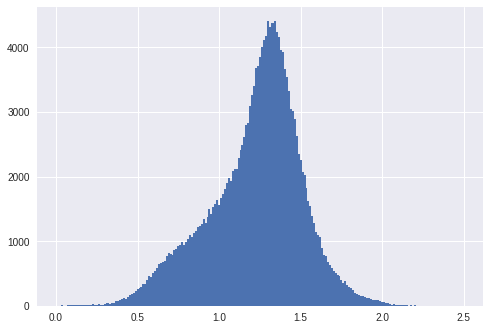

In [7]:
color = np.array(metadata[:]['g'] - metadata[:]['i'])

lo_thresh = 0.0
hi_thresh = 2.5
batch_size = 64

c_train = color[:int(len(color) * .8)]
c_masked = c_train[(c_train > lo_thresh) & (c_train < hi_thresh)]
color_mean = c_masked.mean()
color_std = c_masked.std()
print(color_mean, color_std, len(c_masked))

def datagen(lo, hi, batch_size=batch_size, lo_color_thresh=lo_thresh, hi_color_thresh=hi_thresh):
    batch_ims = []
    batch_colors = []
    while True:
        for sidx in range(lo, hi - 1024, 1024):
            subset_images = images[..., sidx:sidx + 1024]
            subset_color = color[sidx:sidx + 1024]
            order = np.random.uniform(0, 1, 1024).argsort()
            for idx in order:
                c = subset_color[idx]
                if (c < lo_color_thresh) or (c > hi_color_thresh):
                    continue
                batch_colors.append((c - color_mean) / color_std)
                batch_ims.append(subset_images[:, :, idx])
                if len(batch_colors) == batch_size:
                    yield np.stack(batch_ims, axis=0)[..., np.newaxis], np.array(batch_colors)
                    batch_ims = []
                    batch_colors = []

train_gen = datagen(0, int(len(color) * .8))
valid_gen = datagen(int(len(color) * .8), int(len(color) * .9))
test_gen = datagen(int(len(color) * .9), len(color))
hist(c_masked, 'auto');

(64, 424, 424, 1)
0.0311860552365 -0.0195565592194 0.745834917178


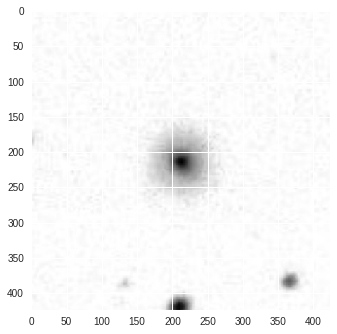

In [8]:
batchims, batchcolors = next(train_gen)
print(batchims.shape)
print(batchcolors[0], batchcolors.mean(), batchcolors.var())
imshow(batchims[0, ..., 0])

In [9]:
# ------------------------------------------------------------------------------
# Set up model architecture
# see Figure 4, Figure 8, and Table 2 of Dielemannnnn paper
# ------------------------------------------------------------------------------

input_shape = batchims[0].shape

# the image input
image_in = Input(shape=input_shape)

# rotate by 45
rotator = Lambda(lambda x: tf.contrib.image.rotate(image_in, np.pi / 4))
image_45 = rotator(image_in)

# cutout centers
subim_size = 207
input_center = batchims[0].shape[1] // 2
lo = input_center - subim_size // 2
hi = lo + subim_size
cutout = Lambda(lambda x: x[:, lo:hi, lo:hi, :])
subim = cutout(image_in)
subim45 = cutout(image_45)

# downscale 3x3 mean - but allow it to modify the filter
downfilt = Conv2D(filters=1, kernel_size=(3,3), strides=3, kernel_initializer=Constant(1/9), trainable=True)
downsub = downfilt(subim)
downsub45 = downfilt(subim45)

# cut out 4 views from each = 8 views
# tf.image.rot90 would be nice, but it doesn't handle batches of images
view1 = Lambda(lambda x: x[:, :45, :45, :])
view2 = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3])[:, :, ::-1, :][:, :45, :45, :])
view3 = Lambda(lambda x: x[:, ::-1, ::-1, :][:, :45, :45, :])
view4 = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3])[:, ::-1, :, :][:, :45, :45, :])
dsviews = [v(downsub) for v in [view1, view2, view3, view4]]
ds45views = [v(downsub45) for v in [view1, view2, view3, view4]]

# transpose each view = 16 views
transposer = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]))
transposedviews = [transposer(x) for x in dsviews + ds45views]

batchims[0, 211:217, 211:217, 0] = 0
batchims[0, 205:215, 211:214, 0] = 0

if False:
    # debugging - display all the steps and outputs
    m = Model(inputs=[image_in], outputs=[image_in, image_45, subim, subim45, downsub, downsub45] + dsviews + ds45views + transposedviews)
    outs = m.predict_on_batch(batchims)
    for o in outs:
        figure()
        imshow(o[0, ..., 0])
        title(str(o[0, ..., 0].shape))


allviews = dsviews + ds45views + transposedviews


In [ ]:
# now set up the 16-way branching
merge = Maximum()
branches = [make_branch(x) for x in allviews]
merged_outputs = merge(branches)

# Dense layers
mergedrop = Dropout(0.5)(merged_outputs)
d0 = Dropout(0.5)((Dense(512, activation='relu')(mergedrop)))
d1 = Dropout(0.5)((Dense(512, activation='relu')(d0)))

#output layer
last_dense = Dense(1)
y = last_dense(d1)

model = Model(inputs=[image_in], outputs=[y])

# Seems to work better with Adam for me, but SGD+momentum is probably just as good when tuned.
# optimizer = SGD(lr=0.001, momentum=0.9, decay=1e-5)
optimizer = Adam(decay=1e-5)

loss = 'mean_absolute_error'  # MSE was giving me stability issues during training
model.compile(loss=loss, optimizer=optimizer, metrics=['mean_squared_error'])
# model.summary()

In [ ]:
num_batch_train = int(len(color) * 0.8 / batch_size)
num_batch_valid = int(len(color) * 0.1 / batch_size)

checkpointer = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

hist = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_batch_train, validation_data=valid_gen, validation_steps=num_batch_valid, verbose=2, callbacks=[checkpointer])

Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.54675, saving model to model.00-0.55.hdf5
1640s - loss: 0.6088 - mean_squared_error: 0.7171 - val_loss: 0.5468 - val_mean_squared_error: 0.5583
Epoch 2/10
Epoch 00001: val_loss improved from 0.54675 to 0.52490, saving model to model.01-0.52.hdf5
1606s - loss: 0.5174 - mean_squared_error: 0.5060 - val_loss: 0.5249 - val_mean_squared_error: 0.5281
Epoch 3/10
Epoch 00002: val_loss did not improve
1742s - loss: 0.4990 - mean_squared_error: 0.4753 - val_loss: 0.5362 - val_mean_squared_error: 0.5657
Epoch 4/10
Epoch 00003: val_loss did not improve
1949s - loss: 0.4877 - mean_squared_error: 0.4561 - val_loss: 0.5619 - val_mean_squared_error: 0.6125
Epoch 5/10
Epoch 00004: val_loss improved from 0.52490 to 0.51996, saving model to model.04-0.52.hdf5
1622s - loss: 0.4803 - mean_squared_error: 0.4443 - val_loss: 0.5200 - val_mean_squared_error: 0.5235
Epoch 6/10
Epoch 00005: val_loss improved from 0.51996 to 0.48443, saving model to model.0

In [20]:
cc_valid = [next(valid_gen) for idx in range(num_batch_valid)]
cc_valid, cc_true = zip(*cc_valid)
len(cc_valid), cc_valid[0].shape

(386, (64, 424, 424, 1))

In [21]:
preds = [model.predict_on_batch(p) for p in cc_valid]
preds = np.concatenate(preds, axis=0).ravel()
trues = np.concatenate(cc_true)

Normzlied MSE 0.429572911911


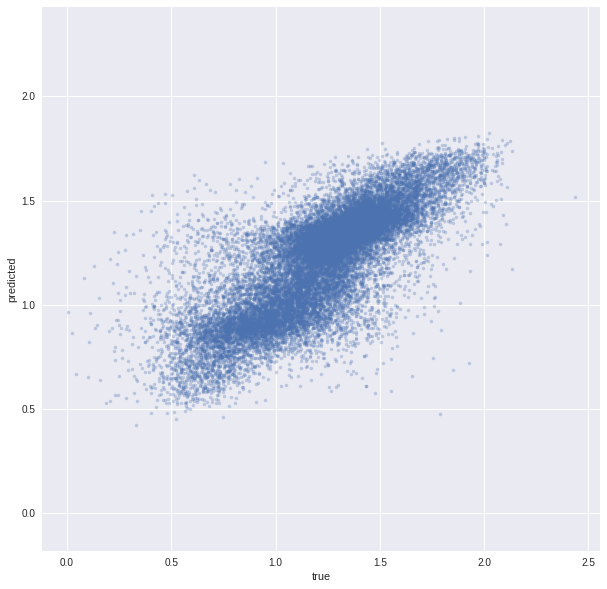

In [29]:
figure(figsize=(10, 10))
plot(trues * color_std + color_mean, preds * color_std + color_mean, '.', alpha=0.3)
xlabel('true')
ylabel('predicted')
axis('equal')
print("Normzlied MSE", ((preds - trues)**2).mean())

In [23]:
true_error = (((trues - preds) * color_std)**2).mean()
true_error, sqrt(true_error)

(0.03482395762316428, 0.18661178318413948)

In [30]:
print("True sigma, adjusted", sqrt(true_error) / 1.71)

True sigma, adjusted 0.109129697769


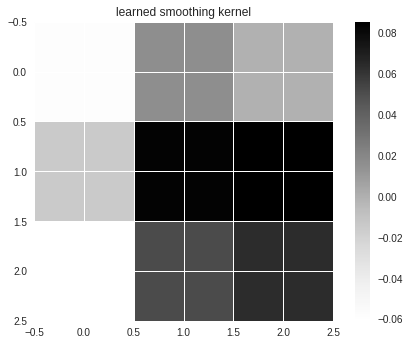

In [26]:
imshow(K.get_value(downfilt.kernel).reshape(3, 3))
colorbar()
title('learned smoothing kernel')